Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## mounting google drive:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Training set - 80% of training data
## Using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing images to img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset='training', label_mode='categorical', seed=123, image_size=(img_height,img_width), batch_size= batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Validation set - 20% of training data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset='validation', label_mode='categorical', seed=123, image_size=(img_height,img_width), batch_size= batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Listing the class names in the dataset, which are the various skin cancer types
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

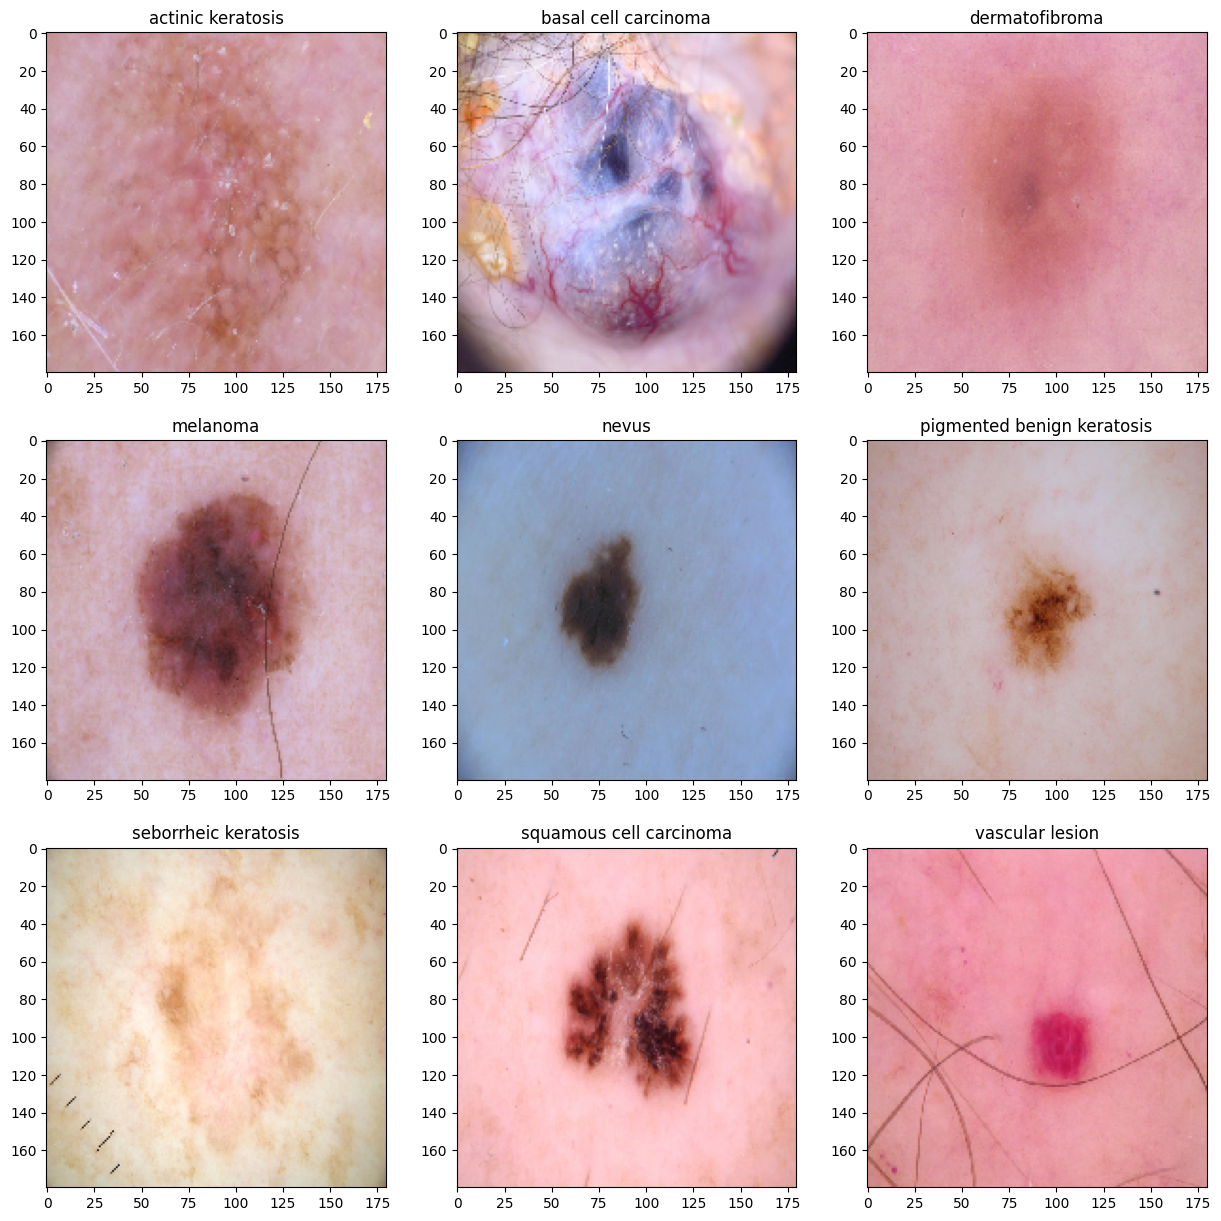

In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

#Dictionary to store the path of image per class
files_path_dict = {}

for cls in class_names:
    files_path_dict[cls] = list(map(lambda x:str(data_dir_train)+'/'+cls+'/'+x,os.listdir(str(data_dir_train)+'/'+cls)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for cls in class_names:
    path_list = files_path_dict[cls][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_height,img_width)))
    plt.title(cls)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
input_shape = (img_height,img_width,3)

model = Sequential()      

#First Convulation Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(512,activation='relu'))

#Dense Layer
model.add(layers.Dense(256,activation='relu'))

#Dense Layer with softmax activation function.
model.add(layers.Dense(len(class_names),activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Appropriate optimizer and loss function is chosen
model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 207s 781ms/step - loss: 2.0698 - accuracy: 0.2277 - val_loss: 1.8996 - val_accuracy: 0.2886
Epoch 2/20
56/56 [==============================] - 2s 37ms/step - loss: 1.6919 - accuracy: 0.3772 - val_loss: 1.6297 - val_accuracy: 0.4407
Epoch 3/20
56/56 [==============================] - 2s 37ms/step - loss: 1.5487 - accuracy: 0.4470 - val_loss: 1.4660 - val_accuracy: 0.5145
Epoch 4/20
56/56 [==============================] - 2s 36ms/step - loss: 1.3862 - accuracy: 0.5162 - val_loss: 1.4006 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 2s 36ms/step - loss: 1.3495 - accuracy: 0.5229 - val_loss: 1.3357 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.2420 - accuracy: 0.5580 - val_loss: 1.3289 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 2s 37ms/step - loss: 1.1700 - accuracy: 0.5781 - val_loss: 1.5168 - val_accuracy: 0.4787
Epoch 8/20

### Visualizing training results

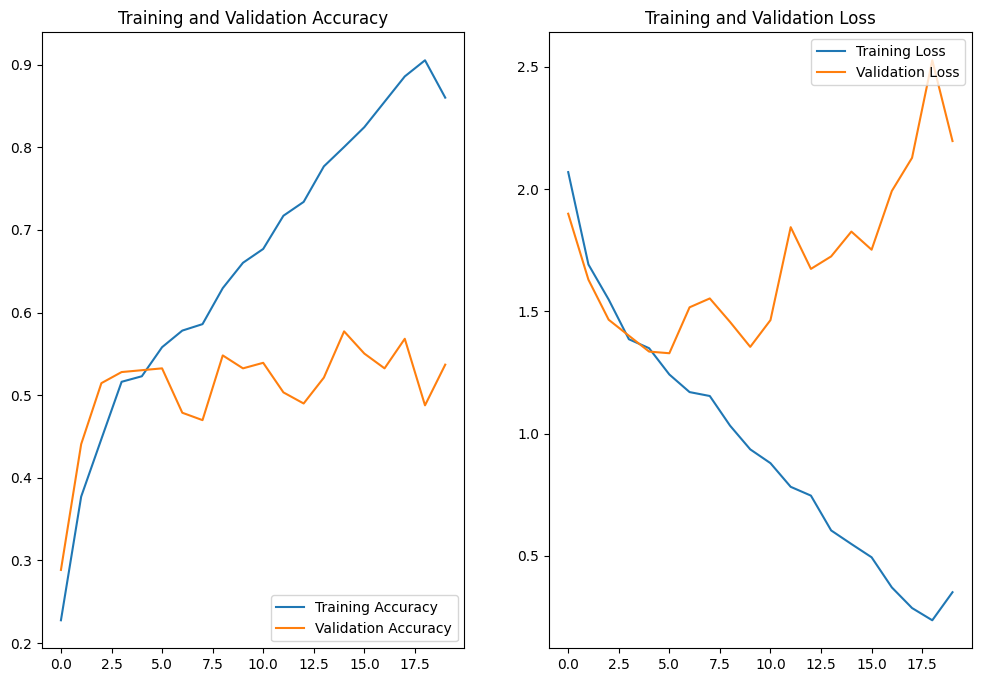

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### We can clearly see that the model is overfitting. The evidence is the increasing difference in training accuracy/loss and validation accuracy/loss with the increasing number of epochs.

#### To rectify the overfitting we can apply certain data augmentation strategies. 
#### What is data Augmentation? 
1. Geometric transformations: randomly flip, crop, rotate, stretch, and zoom images. You need to be careful about applying multiple transformations on the same images, as this can reduce model performance. 
2. Color space transformations: randomly change RGB color channels, contrast, and brightness.
3. Kernel filters: randomly change the sharpness or blurring of the image. 
4. Random erasing: delete some part of the initial image.
5. Mixing images: blending and mixing multiple images. 

#### In this case we will choose random flipping, rotation, contrast and zoom of images for augmentation

In [16]:
# Data augmentation strategy

#To rescale an input in the [0, 255] range to be in the [0, 1] range
rescale=tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

data_aug=tf.keras.Sequential([
    #Randomly flip each image horizontally and vertically
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed=123),
    #Randomly change the contrast of an image by a certain factor
    layers.experimental.preprocessing.RandomContrast(0.2, seed=123),
    #Random rotation
    layers.experimental.preprocessing.RandomRotation(0.3, seed=123),
    #Random zooming
    layers.experimental.preprocessing.RandomZoom(0.2, seed=123)
])

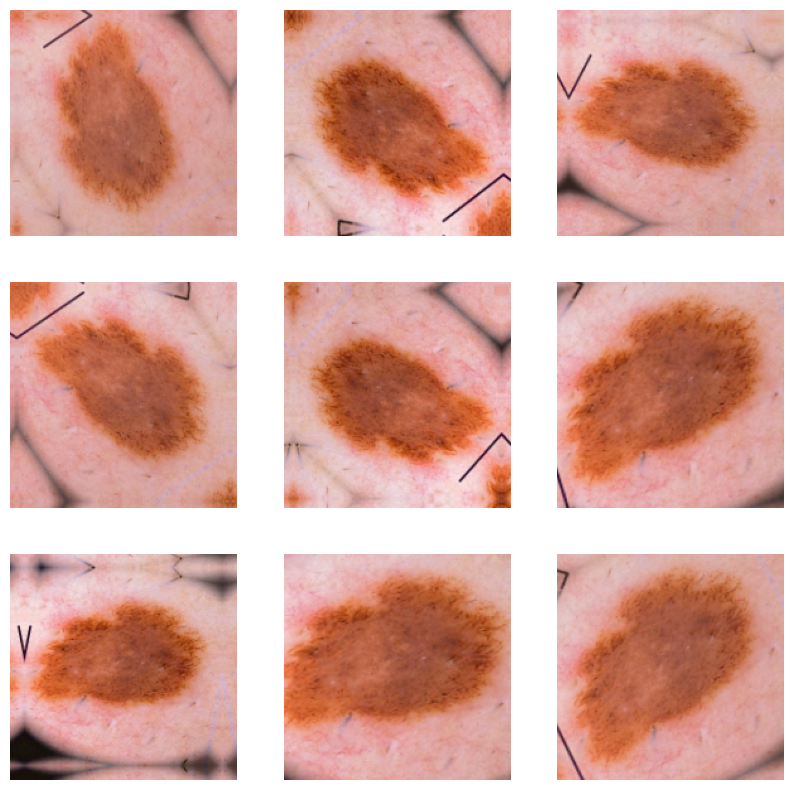

In [17]:
#Visualize the augmentation image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):   
    for i in range(9):
        augmented_images = data_aug(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off") 

### Create, compile and train the model


In [18]:
#Building another model with augmented layer and dropout layers

model_aug = Sequential()  

model_aug.add(data_aug)
model_aug.add(rescale)

#First Convulation Layer
model_aug.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model_aug.add(layers.MaxPool2D(pool_size=(2,2)))
model_aug.add(layers.Dropout(0.25))

#Second Convulation Layer
model_aug.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model_aug.add(layers.MaxPool2D(pool_size=(2,2)))
model_aug.add(layers.Dropout(0.25))

#Third Convulation Layer
model_aug.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model_aug.add(layers.MaxPool2D(pool_size=(2,2)))
model_aug.add(layers.Dropout(0.25))

#Flatten layer
model_aug.add(layers.Flatten())   

#Dense Layer
model_aug.add(layers.Dense(512,activation='relu'))
model_aug.add(layers.Dropout(0.5))

#Dense Layer
model_aug.add(layers.Dense(256,activation='relu'))
model_aug.add(layers.Dropout(0.5))


#Dense Layer with softmax activation function.
model_aug.add(layers.Dense(len(class_names),activation='softmax'))


### Compiling the model

In [19]:
model_aug.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

### Training the model

In [20]:
epochs = 20
history = model_aug.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 68ms/step - loss: 2.2537 - accuracy: 0.1752 - val_loss: 2.0779 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 4s 63ms/step - loss: 2.0562 - accuracy: 0.1869 - val_loss: 2.0440 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 3s 62ms/step - loss: 2.0264 - accuracy: 0.2143 - val_loss: 2.0615 - val_accuracy: 0.2953
Epoch 4/20
56/56 [==============================] - 3s 62ms/step - loss: 1.9440 - accuracy: 0.2773 - val_loss: 1.8601 - val_accuracy: 0.3535
Epoch 5/20
56/56 [==============================] - 4s 66ms/step - loss: 1.8182 - accuracy: 0.3376 - val_loss: 1.7522 - val_accuracy: 0.3669
Epoch 6/20
56/56 [==============================] - 3s 62ms/step - loss: 1.7025 - accuracy: 0.3901 - val_loss: 1.5867 - val_accuracy: 0.4564
Epoch 7/20
56/56 [==============================] - 3s 61ms/step - loss: 1.6759 - accuracy: 0.3923 - val_loss: 1.6592 - val_accuracy: 0.3982
Epoch 8/20
56

### Visualizing the results

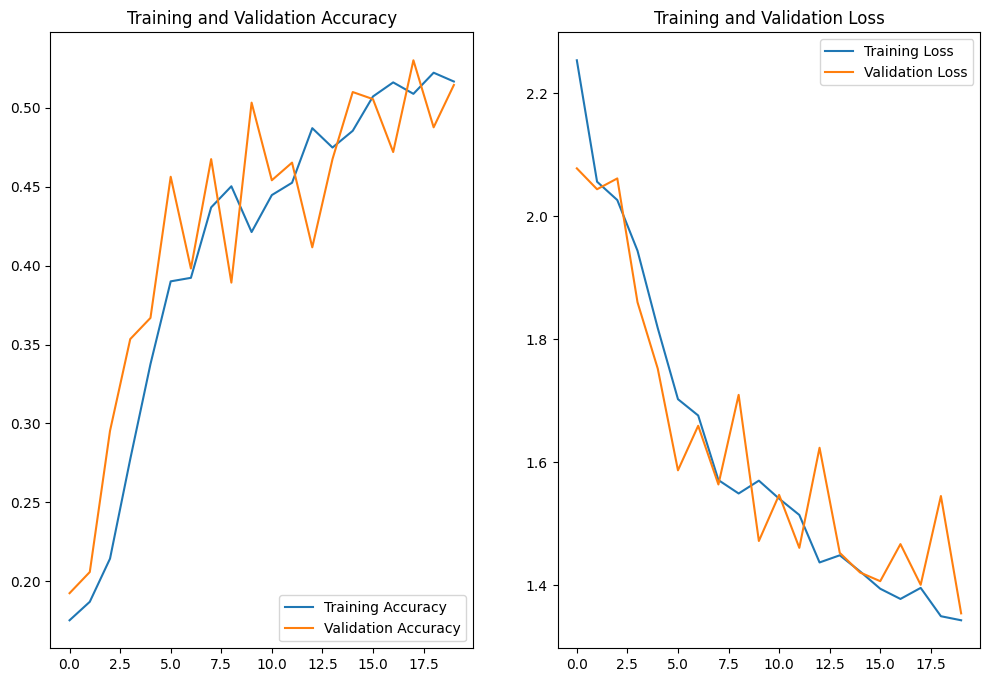

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### After adding the augmentation layer and dropouts we have significantly reduced overfitting of the model. Although the accuracy is still poor we have at least managed to solve the overfitting problem.

#### Check the distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
count=[]
for path in pathlib.Path(data_dir_train).iterdir():
 if path.is_dir():
   lst=[name for name in os.listdir(path) if os.path.isfile(os.path.join(path,name))]
   count.append(len(lst))
   sub_dir=[name for name in os.listdir(data_dir_train) if os.path.isdir(os.path.join(data_dir_train,name))]

df=pd.DataFrame(list(zip(sub_dir,count)),columns=['Class', 'Count of Images'])
df.sort_values(by='Count of Images', ascending=False)

,Class,Count of Images
5,pigmented benign keratosis,462
3,melanoma,438
1,basal cell carcinoma,376
4,nevus,357
7,squamous cell carcinoma,181
8,vascular lesion,139
0,actinic keratosis,114
2,dermatofibroma,95
6,seborrheic keratosis,77


#### - Seborrheic Keratosis has the least number of samples
#### - Pigemnted Benign Keratosis and Melanoma dominate in terms of no. of samples
#### This dispropotionate distribution has led to class imbalance which is affecting the accuracy of the model


#### Rectify the class imbalance
#### Ref: `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [23]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [24]:
path_to_training_dataset='/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 
## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAB37D01F90>: 100%|██████████| 500/500 [00:27<00:00, 17.96 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FABB01ECD30>: 100%|██████████| 500/500 [00:27<00:00, 18.39 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAB37C16290>: 100%|██████████| 500/500 [00:23<00:00, 21.64 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FABC4959F30>: 100%|██████████| 500/500 [01:56<00:00,  4.31 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAB37AE3EB0>: 100%|██████████| 500/500 [01:36<00:00,  5.18 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FABC496C160>: 100%|██████████| 500/500 [00:20<00:00, 24.04 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FABC43E70A0>: 100%|██████████| 500/500 [00:48<00:00, 10.25 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAB37AE02E0>: 100%|██████████| 500/500 [00:20<00:00, 24.58 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FABC496DC00>: 100%|██████████| 500/500 [00:22<00:00, 22.18 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [25]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [26]:
import glob

In [27]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
#path_list

In [28]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*'))]
#lesion_list

In [29]:
dataframe_dict_new = dict(zip(path_list, lesion_list))

In [30]:
df1 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [31]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list_new

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [33]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([df1,df2])

In [37]:
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

In [38]:
new_df['Label'].value_counts()

pigmented benign keratosis    963
melanoma                      939
basal cell carcinoma          877
nevus                         858
squamous cell carcinoma       682
vascular lesion               631
actinic keratosis             615
dermatofibroma                596
seborrheic keratosis          578
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [39]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [40]:
data_dir_train="/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,    
  subset = "training",
  image_size=(img_height, img_width),
  label_mode='categorical',  
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  label_mode='categorical',   
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create next model

In [46]:
#Batch normalization: is a method used to make artificial neural networks faster and more stable through normalization 
#of the layers' inputs by re-centering and re-scaling

model_3 = Sequential()  

#model_3.add(data_aug)
#augmentation layer has been removed since we have already augmented the dataset with synthetic images
model_3.add(rescale)

#First Convulation Layer
model_3.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=(2,2)))
model_3.add(layers.Dropout(0.25))

#Second Convulation Layer
model_3.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=(2,2)))
model_3.add(layers.Dropout(0.25))

#Third Convulation Layer
model_3.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=(2,2)))
#model_3.add(layers.Dropout(0.25))

#Flatten layer
model_3.add(layers.Flatten())  

#Dense Layer
model_3.add(layers.Dense(512,activation='relu'))
model_3.add(layers.Dropout(0.25))
model_3.add(layers.BatchNormalization())

#Dense Layer
model_3.add(layers.Dense(256,activation='relu'))
model_3.add(layers.Dropout(0.5))
model_3.add(layers.BatchNormalization())

#Dense Layer with softmax activation function.
model_3.add(layers.Dense(len(class_names),activation='softmax'))

#### Compile the model

In [47]:
model_3.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Train the model

In [48]:
epochs = 50
history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 39s 208ms/step - loss: 2.3199 - accuracy: 0.2190 - val_loss: 4.5675 - val_accuracy: 0.1403
Epoch 2/50
169/169 [==============================] - 34s 196ms/step - loss: 1.7814 - accuracy: 0.3513 - val_loss: 4.3205 - val_accuracy: 0.1767
Epoch 3/50
169/169 [==============================] - 36s 206ms/step - loss: 1.6410 - accuracy: 0.3891 - val_loss: 1.6284 - val_accuracy: 0.3786
Epoch 4/50
169/169 [==============================] - 36s 205ms/step - loss: 1.5556 - accuracy: 0.4177 - val_loss: 2.1671 - val_accuracy: 0.3645
Epoch 5/50
169/169 [==============================] - 39s 225ms/step - loss: 1.4338 - accuracy: 0.4522 - val_loss: 1.6651 - val_accuracy: 0.4024
Epoch 6/50
169/169 [==============================] - 39s 226ms/step - loss: 1.4069 - accuracy: 0.4690 - val_loss: 2.5580 - val_accuracy: 0.2643
Epoch 7/50
169/169 [==============================] - 39s 225ms/step - loss: 1.3911 - accuracy: 0.4685 - val_loss: 1.3355 - val_ac

#### Visualize the model results

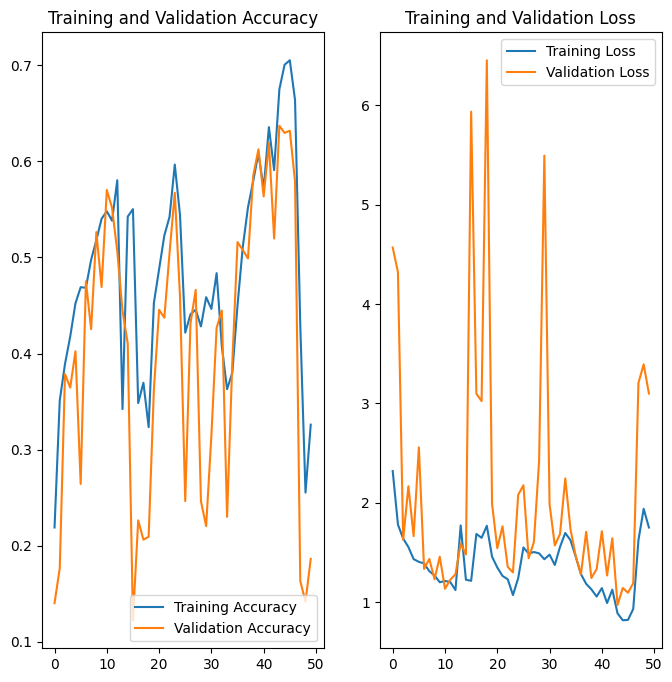

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### We have solved the overfiting problem
#### We can see that the training and validation accuracy are similar and decently high
#### We can futher tweak the model by reducing the number of neurons in the dense layers or changing the locaiton of the dropout layers to improve performance
#### Re-balancing the classes by using augmented data helps in improving model performance and accuracy

